# POT-GP fitting

This example shows the POT-GP fitting to derive the extreme event, including threshold determination.

---

Load the packages

In [1]:
import pandas as pd
import pybtls as pb
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto

We generate 100-year traffic data (250 business days per year) first, with an initial threshold (u) of 1000.0 kNm. 

The simulation setup follows a similar logic to the previous Simulation with Traffic Generation example, but is simplified.

In [2]:
# Define the influence line
le = pb.InfluenceLine("built-in")
le.set_IL(id = 1, length = 20.0)

# Set bridge
bridge = pb.Bridge(length=20.0, no_lane=2)
bridge.add_load_effect(inf_line_surf=le, threshold=1000.0)

# Set vehicle generator
garage = pb.garage.read_garage_file("./garage.txt", 4)
kernel = [[1.0, 0.08], [1.0, 0.05], [1.0, 0.02]]
vehicle_gen = pb.VehicleGenGarage(garage=garage, kernel=kernel)

# Set headway generator
headway_gen = pb.HeadwayGenFreeflow()

# Set lane flow compositions
normalized_hourly_flow_truck = [0.019947, 0.019947, 0.019947, 0.019947, 0.019947, 0.031915, 0.059840, 0.059840, 0.059840, 0.055851, 0.046543, 0.046543, 0.046543, 0.046543, 0.046543, 0.055851, 0.055851, 0.055851, 0.055851, 0.046543, 0.046543, 0.031915, 0.031915, 0.019947]
normalized_hourly_flow_car = [0.005721, 0.005721, 0.005721, 0.005721, 0.005721, 0.014874, 0.088673, 0.145881, 0.117277, 0.061785, 0.037185, 0.037185, 0.037185, 0.037185, 0.037185, 0.061785, 0.061785, 0.061785, 0.061785, 0.037185, 0.037185, 0.014874, 0.014874, 0.005721]

lfc_1 = pb.LaneFlowComposition(lane_index=1, lane_dir=1)
lfc_1.assign_lane_data(
    hourly_truck_flow = [
        round(i * 2500) for i in normalized_hourly_flow_truck
    ], 
    hourly_car_flow = [
        round(i * 14000) for i in normalized_hourly_flow_car
    ],
    hourly_speed_mean = [80 / 3.6 * 10] * 24,  # in dm/s
    hourly_speed_std = [5.0] * 24,  # in dm/s
)

lfc_2 = pb.LaneFlowComposition(lane_index=2, lane_dir=1)
lfc_2.assign_lane_data(
    hourly_truck_flow = [
        round(i * 625) for i in normalized_hourly_flow_truck
    ],
    hourly_car_flow = [
        round(i * 14000) for i in normalized_hourly_flow_car
    ],
    hourly_speed_mean = [80 / 3.6 * 10] * 24,  # in dm/s
    hourly_speed_std = [10.0] * 24,  # in dm/s
)    

# Set traffic generator
traffic_gen = pb.TrafficGenerator(no_lane=2)
traffic_gen.add_lane(vehicle_gen=vehicle_gen, headway_gen=headway_gen, lfc=lfc_1)
traffic_gen.add_lane(vehicle_gen=vehicle_gen, headway_gen=headway_gen, lfc=lfc_2)

# Selet outputs
output_config = pb.OutputConfig()
output_config.set_POT_output(
    write_summary = True,
    POT_size_days = 250,
)

# Create and run the simulation
sim_task = pb.Simulation("./temp")
sim_task.add_sim(
    bridge = bridge,
    traffic = traffic_gen,
    no_day = 250*100,
    output_config = output_config,
    time_step = 0.1,
    tag = "Case6",
)
sim_task.run(no_core = 1)

# Read the output data
example_output = sim_task.get_output()
POT_output = example_output["Case6"].read_data("POT_summary")["PT_S_20_Eff_1"]

Make a plot for the POT data. 

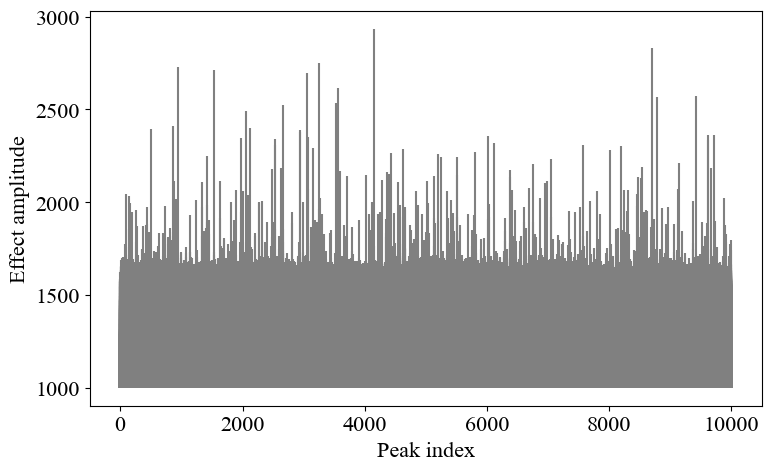

In [3]:
pb.plot.plot_POT_S(POT_output, threshold = 1000.0)



In peak-over-threshold (POT) extreme-value analysis, the “right” threshold (u) is the lowest value for which the exceedances behave like a Generalized Pareto (GP) distribution but still leave enough data to estimate reliably.

From the plot, it is likely that the initial threshold (1000.0 kNm) is too low since there are significant exceedances in the POT values.

Therefore, we test different threshold values and make a plot to visualize the adjustment.

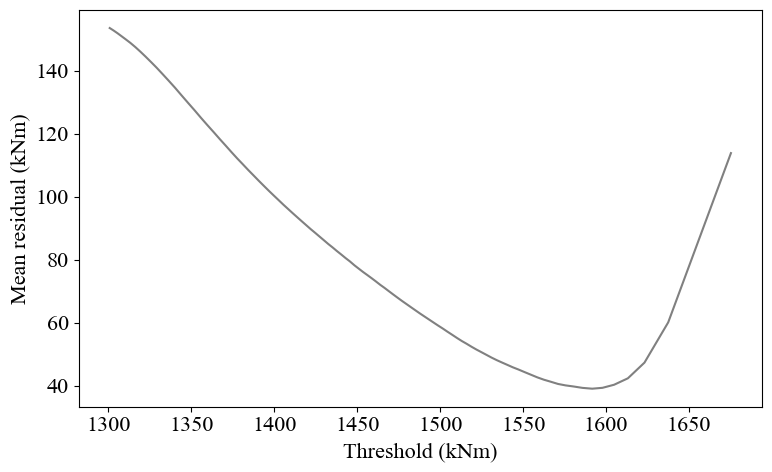

In [4]:
def fit_gpd_exceedances(x, u):
    y = x[x > u] - u
    # SciPy: genpareto(c=xi, loc=0, scale=sigma)
    xi, loc, sigma = genpareto.fit(y, floc=0)  # MLE
    return xi, sigma, y


def return_level(u, xi, sigma, rate, T):
    # rate = exceedance rate P(X>u); T = return period in observation units
    # z_T = u + (sigma/xi) * [(T*rate)**xi - 1]  for xi != 0
    if np.isclose(xi, 0.0):
        return u + sigma * np.log(T*rate)
    return u + (sigma/xi) * ((T*rate)**xi - 1)


def adjust_POT_threshold(data: pd.Series):

    qs = np.linspace(0.8, 0.999, 100)
    cands = np.quantile(data, qs)

    results = []
    for u in cands:
        xi, sigma, y = fit_gpd_exceedances(data, u)
        rate = (data > u).mean()  # Exceedance rate
        rl_100 = return_level(u, xi, sigma, rate, T=100*len(data))
        residual = sum(y)/len(y)
        results.append((u, residual, rl_100))

    results = pd.DataFrame(results, columns=["u", "residual", "rl_100"])
    results.to_excel("./temp/POT_threshold_adjustment.xlsx", index=False)

    return results


def plot_POT_threshold_adjustment(adjustment_result: pd.DataFrame):

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.rcParams["mathtext.fontset"] = "stix"

    plt.figure(figsize=(8, 5))
    
    # Select the five columns and merge them into one Series
    u_data = adjustment_result["u"]
    residual_data = adjustment_result["residual"]

    # Plot vertical bars for each data point
    plt.plot(u_data, residual_data, color="gray")
    plt.xlabel("Threshold (kNm)")
    plt.ylabel("Mean residual (kNm)")

    # Adjust layout
    plt.tight_layout()

    # Show the figure
    plt.show()


plot_POT_threshold_adjustment(adjust_POT_threshold(POT_output["Peak Value"]))

According to the Chapter 3.3 of the book [Applied Extreme Value Statistics](https://rdcu.be/eBAHE), threshold = 1590 kNm is likely to be an appropriate choice for the analysis. 

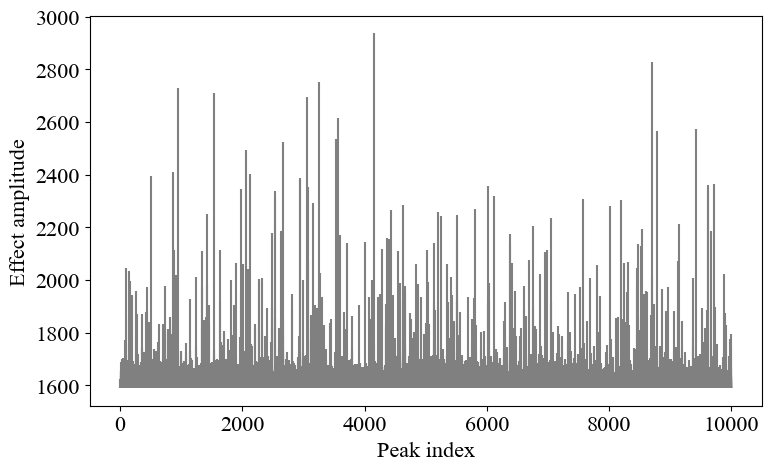

In [5]:
threshold = 1590.0
pb.plot.plot_POT_S(POT_output, threshold)

In [9]:
def fit_gp_exceedances(POT_data, u):
        y = POT_data[POT_data > u] - u
        # SciPy: genpareto(c=xi, loc=0, scale=sigma)
        xi, loc, sigma = genpareto.fit(y, floc=0)  # MLE
        return xi, sigma


def return_level(u, xi, sigma, n):
        # rate = exceedance rate P(X>u); T = return period in observation units
        # z_T = u + (sigma/xi) * [(T*rate)**xi - 1]  for xi != 0
        if np.isclose(xi, 0.0):
            return u + sigma * np.log(n)
        return u + (sigma/xi) * ((n)**xi - 1)


def plot_POT_GP_fit(POT_data: pd.Series, threshold: float, xi:float, sigma:float):

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.rcParams["mathtext.fontset"] = "stix"

    plt.figure(figsize=(8, 5))

    # Histogram (empirical density)
    plt.hist(POT_data, bins=100, density=True, color="#AAAAAA", edgecolor="gray", alpha=0.8, label="Over-threshold events")

    # Plot the fitted GPD PDF
    x = np.linspace(threshold, POT_data.max(), 500)
    pdf = genpareto.pdf(x, c=xi, loc=threshold, scale=sigma)
    plt.plot(x, pdf, color="black", lw=2, label="GP distribution fitted")

    plt.xlabel("Mid-Span Bending Moment (kNm)")
    plt.ylabel("Density")

    plt.axvline(threshold, color="black", ls="--", lw=1.5, label="Threshold")
    
    plt.legend()
    plt.tight_layout()
    plt.show()

Make a fit to the POT data with GP distribution. 

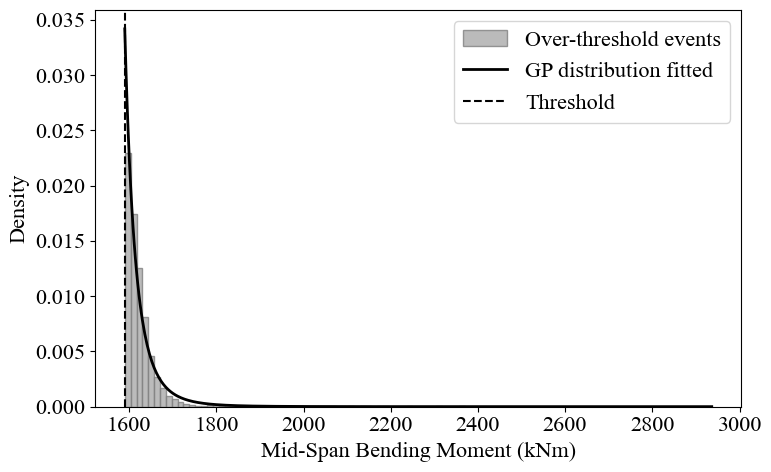

Fitted GP distribution parameters:
xi: 0.2248, mu: 1590, sigma: 29


In [10]:
POT_data = POT_output["Peak Value"][POT_output["Peak Value"] > threshold]
xi, sigma = fit_gp_exceedances(POT_data, threshold)
plot_POT_GP_fit(POT_data, threshold, xi, sigma)
print("Fitted GP distribution parameters:")
print(f"xi: {xi:.4f}, mu: {threshold:.0f}, sigma: {sigma:.0f}")

Finally, we can use the fitted GPD parameters to estimate the extreme value for a 100-year event.

In [11]:
n = len(POT_data)
rl100 = return_level(threshold, xi, sigma, n)
print(f"Extreme value for 100-year event: {rl100:.0f} kNm")

Extreme value for 100-year event: 2546 kNm
